# MNIST Dataset

In [78]:
import torch #General pytorch
import torch.nn as nn #NN module
import torch.nn.functional as F #useful function like softmax, or Relu

from torchvision import datasets, transforms #transform fro image processing
from torch.utils.data import DataLoader #dataloader for preparing batch

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys

In [2]:
torch.__version__

'1.12.1+cpu'

## 1.ETL

In [3]:
#load the dataset
#transform means do you want to apply any processing to these images

#for the transform, we gonna just convert to tensor
transform = transforms.ToTensor() #this NOT only converts to tensor, but also
#conver from 0 to 255 to 0 to 1
train = datasets.MNIST(root="../data/",train=True,download=True,transform= transform)

In [4]:
test = datasets.MNIST(root="../data/",train=False,download=True,transform= transform)

In [5]:
#Examine 
type(train[0]) #tuple of (image,target)

tuple

In [6]:
# train[0] #notice that all numbers are betwwem 0 and 1, the secodn tuple is target
# image = train[0][0]
image, target = train[0]
image.size() #(1,28,28) = (channel,width,height)
target

5

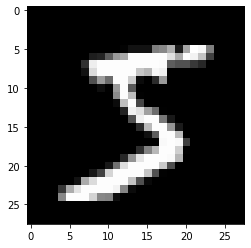

In [7]:
#image show, input format must be (w,h)
plt.imshow(image.reshape((28,28)),cmap='gray')

## 2. Set the dataloader

'Dataloader' is for preparing a geneartor, that gonna output batch by batch.

In [59]:
#set the seed fror reproducibility in shuffling
torch.manual_seed(999) #why 999?

#set the dataloader
train_batch_size = 100 #how do I know 100? beacuse Chaky's PC
test_batch_size = 10000
#format : Dataloader(dataset, batch_size, shuffle)
train_loader = DataLoader(train, batch_size = train_batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size = test_batch_size, shuffle=True)

#note In good practice, you MUST also have val_loader, but I am lazy todau, because 
#i want to kepp things simple, I will show val_loader when we use CNN for MNIST

In [60]:
#let's test the loader (because some of you are still confused....)
for images,targets in train_loader:
    print(images.shape) #what is the shape (100,1,28,28)
    print(targets.shape) #what is the shape (100)
    break
#(100,1,28,28) = (batch_size,BW,Width,Height)

#remember that train_loader has a counter, so it will keep on running

torch.Size([100, 1, 28, 28])
torch.Size([100])


## 2.EDA

Labels: [4 3 8 8 9 0 8 5 9 2 2 9]


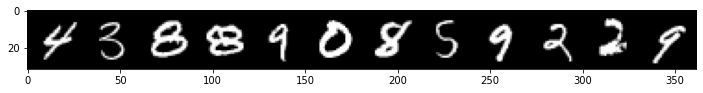

In [61]:
#so let's try to print out some images ...... in a grid form
from torchvision.utils import make_grid

#we already have 100 images, and 100 targets
print(f'Labels: {targets[:12].numpy()}')

#plot the images......
im = make_grid(images[:12], nrow=12) #default nrow is 8

#imshow takes either (W,H) or (W,H,C)
#our image are (C,W,H),so we need to change the position; using 'tranpose()'
im_tranpose = np.transpose(im, (1,2,0)) #why (1,2,0) because C now because the last guy
im_tranpose.shape

plt.figure(figsize=(12,8))
plt.imshow(im_tranpose)

## 3.Training

In [62]:
#please create a network
#layer 1 = Linear layer if shape(784,89)
#layer 2 = Relu (use F.relu())
#layer 3 = linear llayer of (89,10)
#cost entropy loss has put softmax already
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU(hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.relu(out1)
        out3 = self.layer2(out2) #after here, you DON'T have to softmax
                                 #because pytorch cross entropy loss combines
                                 #softmax + cross entropy
        return out3

In [63]:
input_size = 784
hidden_size = 89
output_size = 10

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

model = NeuralNetwork(input_size,hidden_size,output_size).to(device)
model

NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=89, bias=True)
  (relu): ReLU(inplace=True)
  (layer2): Linear(in_features=89, out_features=10, bias=True)
)

In [64]:
#count the paramater of the model
for p in model.parameters():
    print(p.shape)

torch.Size([89, 784])
torch.Size([89])
torch.Size([10, 89])
torch.Size([10])


In [65]:
#what is numel
sum(p.numel() for p in model.parameters() if p.requires_grad)
#where does this 70765 number comes from 89*784 + 89 + 10*89 + 10 
#We want z(1)least amount parameters but (2) with highest accuracy

70765

In [66]:
#define the cross entropy loss
J_fn = nn.CrossEntropyLoss() #combine softmax and cross entropy loss

In [67]:
#define the optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [68]:
images.shape

torch.Size([100, 1, 28, 28])

In [71]:
#training
num_epochs = 5
#for epochs
for i in range(num_epochs):
    total_corr = 0

    #for loader
    for batch, (images,targets) in enumerate(train_loader):
        #image reshape to (m,n)
        #targets
        images = images.reshape(-1,28*28).to(device) #(100,784)
        targets = targets.to(device) #(100)
        #1.predict
        yhat = model(images) #(100,10)
        #1.1 calculate the accuracy
        predicted = torch.max(yhat, 1)[1] #if you use 0, it will return the probability, 1 is for index
        #predicted.shape(100)
        batch_corr = (predicted == targets).sum()
        total_corr += batch_corr 
        #2.loss
        loss = J_fn(yhat,targets)
        #3.clear gradient using zero_grad()
        optimizer.zero_grad()
        #4.backprop using backward()
        loss.backward()
        #5.update using strp()
        optimizer.step() 

        if batch % 400 == 0:
            acc = (total_corr*100) / (train_batch_size*(batch+1))
            print(f'Epoch: {i:2.0f}; Batch: {batch:>3}; Loss: {loss:3.2f}; Acc: {acc:3.2f}')

Epoch:  0; Batch:   0; Loss: 0.35; Acc: 88.00
Epoch:  0; Batch: 400; Loss: 0.24; Acc: 90.87
Epoch:  1; Batch:   0; Loss: 0.39; Acc: 88.00
Epoch:  1; Batch: 400; Loss: 0.31; Acc: 91.06
Epoch:  2; Batch:   0; Loss: 0.24; Acc: 94.00
Epoch:  2; Batch: 400; Loss: 0.45; Acc: 91.18
Epoch:  3; Batch:   0; Loss: 0.27; Acc: 93.00
Epoch:  3; Batch: 400; Loss: 0.25; Acc: 91.60
Epoch:  4; Batch:   0; Loss: 0.34; Acc: 90.00
Epoch:  4; Batch: 400; Loss: 0.21; Acc: 91.82


## 4.Testing

In [72]:
with torch.no_grad(): #why no gradients during test; because we don't need backpropagation!!
    correct = 0
    total = 0
    for batch, (images,targets) in enumerate(test_loader):
        images = images.reshape(-1,28*28).to(device) #(100,784)
        targets = targets.to(device) #(100)
        #1.predict
        yhat = model(images) #(100,10)
        #2 measure acc
        predicted = torch.max(yhat, 1)[1]
        batch_corr = (predicted == targets).sum()
        correct += batch_corr 
        total += targets.shape[0]

    acc = (correct*100) / total
    print(f'Accuracy: {acc:.2f} %')

Accuracy: 92.32 %


## 5. Optional : I want to know where are my errors (using confusion matrix)

In [73]:
yhat.shape

torch.Size([10000, 10])

In [74]:
targets.shape

torch.Size([10000])

<Figure size 1440x1440 with 0 Axes>

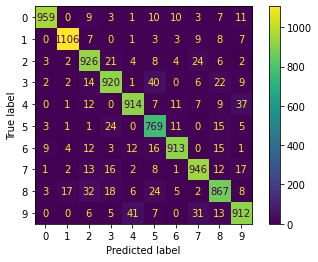

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix(predicted,targets)) 
disp.plot()